# Problem 1: Multi-Taxi Routing with Capacity-Constrained Roads

You are given a city represented as a weighted undirected graph with N=8 intersections
(nodes) and roads (edges).

● There are multiple taxis (T) and passengers (P).

● Each taxi can carry exactly one passenger from pickup to drop.

● Each node has 2D coordinates (x, y).

● Distances between connected nodes are given explicitly.

● Taxis move at a constant speed of 40 km/h.

Travel time rule:

Travel Time (hours)=Distance/Speed

Congestion Rule:

● At most 2 taxis can use the same road (edge) at the same time.

● If a third taxi tries to enter while 2 are already on that edge, it must wait 30 minutes
before entering.

Objective:

Plan routes for all taxis so that all passengers are picked up and dropped off, minimizing the
total completion time.
Use A* search (specify heuristic) for pathfinding.

Input Format:

N M P W S

● N = number of nodes (fixed at 8)

● M = number of edges

● P = number of passengers = number of taxis

● W = waiting time in minutes (30)

● S = speed in km/h (40)

Next N lines: node coordinates (x y)

Next M lines: roads with distances (u v d)

Next P lines: passenger trips (pickup drop)



In [ ]:
!pip install networkx

Solving started

Total objective (sum of completion times) = 645.0 minutes


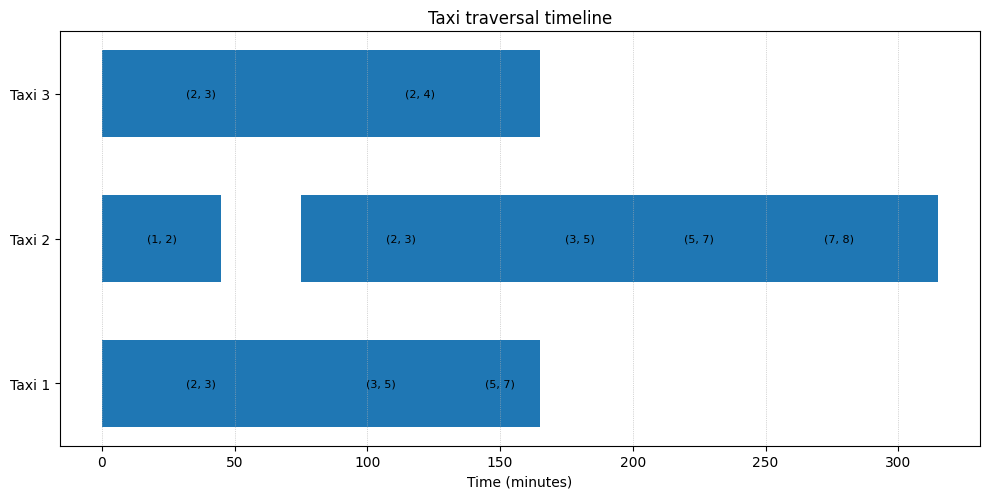

Solving ended

Taxi 1 (2 -> 7):
  Route: 2 -> 3 -> 5 -> 7
  Completion time (min): 165.0

Taxi 2 (1 -> 8):
  Route: 1 -> 2 -> 3 -> 5 -> 7 -> 8
  Completion time (min): 315.0
  Wait events:
   - Node 2 from 45.0 to 75.0 (reason: capacity)

Taxi 3 (3 -> 4):
  Route: 3 -> 2 -> 4
  Completion time (min): 165.0


In [ ]:
from heapq import heappush, heappop
from collections import defaultdict
import math
import copy
import matplotlib.pyplot as plt
import pandas as pd


class TaxiRouter:
    def __init__(self, num_nodes, edges, trips, wait_penalty=30.0, speed_kmh=40.0):
        self.num_nodes = num_nodes
        self.edges = edges
        self.trips = trips
        self.wait_penalty = wait_penalty
        self.speed_kmh = speed_kmh
        self.minutes_per_km = 60.0 / speed_kmh

        self.graph = self._build_graph()
        self.all_times = self._compute_all_shortest_times()

    def _build_graph(self):
        graph = defaultdict(list)
        for a, b, km in self.edges:
            graph[a].append((b, km))
            graph[b].append((a, km))
        return graph

    def _single_source_times(self, src):
        dist_km = {n: math.inf for n in range(1, self.num_nodes + 1)}
        dist_km[src] = 0.0
        heap = [(0.0, src)]

        while heap:
            d, node = heappop(heap)
            if d > dist_km[node]:
                continue
            for nxt, km in self.graph[node]:
                nd = d + km
                if nd < dist_km[nxt]:
                    dist_km[nxt] = nd
                    heappush(heap, (nd, nxt))

        return {n: dist_km[n] * self.minutes_per_km for n in dist_km}

    def _compute_all_shortest_times(self):
        return {n: self._single_source_times(n) for n in range(1, self.num_nodes + 1)}

    def _admissible_sum_heuristic(self, taxi_list):
        total = 0.0
        for t in taxi_list:
            if t['done']:
                continue
            cur, dest = t['pos'], t['dest']
            total += self.all_times[cur].get(dest, math.inf)
        return total

    @staticmethod
    def _undirected_edge(u, v):
        return (u, v) if u <= v else (v, u)

    @staticmethod
    def _overlapping_count(schedule, edge_key, s_time, e_time):
        cnt = 0
        for rec in schedule:
            ek, st, en = rec['edge'], rec['start'], rec['end']
            if ek == edge_key and not (en <= s_time or st >= e_time):
                cnt += 1
        return cnt

    def _initialize_taxi_states(self):
        taxi_states_init = []
        for origin, dest in self.trips:
            taxi_states_init.append({
                'pos': origin,
                'available_at': 0.0,
                'done': origin == dest,
                'dest': dest,
                'route': [origin],
                'wait_events': []
            })
        return taxi_states_init

    def _serialize_states(self, taxi_states):
        return tuple(tuple(sorted(ts.items())) for ts in taxi_states)

    def _deserialize_states(self, ser_states):
        taxi_states = []
        for s in ser_states:
            d = dict(s)
            taxi_states.append({
                'pos': d['pos'],
                'available_at': d['available_at'],
                'done': d['done'],
                'dest': d['dest'],
                'route': list(d['route']),
                'wait_events': list(d['wait_events']),
            })
        return taxi_states

    def _deserialize_schedule(self, ser_schedule):
        schedule = []
        for e in ser_schedule:
            schedule.append({
                'edge': e[0][1] if isinstance(e[0], tuple) and e[0][0] == 'edge' else dict(e)['edge'],
                'start': float(dict(e)['start']),
                'end': float(dict(e)['end']),
                'taxi': int(dict(e).get('taxi', -1))
            })
        return schedule

    def _get_canonical_key(self, taxi_states):
        return tuple((t['pos'], int(round(t['available_at'])), t['done']) for t in taxi_states)

    def solve(self):
        taxi_states_init = self._initialize_taxi_states()
        open_heap, counter = [], 0
        g0, h0 = 0.0, self._admissible_sum_heuristic(taxi_states_init)

        heappush(open_heap, (g0 + h0, g0, counter, self._serialize_states(taxi_states_init), tuple()))
        counter += 1

        seen, solution = {}, None

        while open_heap:
            f, g, _, ser_states, ser_schedule = heappop(open_heap)
            taxi_states = self._deserialize_states(ser_states)
            schedule = self._deserialize_schedule(ser_schedule)

            if all(t['done'] for t in taxi_states):
                solution = (g, taxi_states, schedule)
                break

            key = self._get_canonical_key(taxi_states)
            if key in seen and seen[key] <= g:
                continue
            seen[key] = g

            for idx, t in enumerate(taxi_states):
                if t['done']:
                    continue

                current_pos, atime = t['pos'], t['available_at']
                for (nbr, km) in self.graph[current_pos]:
                    traversal = km * self.minutes_per_km
                    ek = self._undirected_edge(current_pos, nbr)

                    attempt_time, attempts = atime, 0
                    while True:
                        c = self._overlapping_count(schedule, ek, attempt_time, attempt_time + traversal)
                        if c <= 1:
                            break
                        attempt_time += self.wait_penalty
                        attempts += 1
                        if attempts > 200:
                            break

                    end_time = attempt_time + traversal
                    new_states, new_schedule = copy.deepcopy(taxi_states), list(schedule)
                    new_schedule.append({'edge': ek, 'start': attempt_time, 'end': end_time, 'taxi': idx})

                    new_states[idx]['pos'] = nbr
                    new_states[idx]['available_at'] = end_time
                    new_states[idx]['route'] = new_states[idx]['route'] + [nbr]

                    if attempt_time > atime:
                        new_states[idx]['wait_events'] = new_states[idx]['wait_events'] + [{
                            'node': current_pos, 'from': atime, 'to': attempt_time, 'reason': 'capacity'
                        }]

                    if nbr == new_states[idx]['dest']:
                        new_states[idx]['done'] = True

                    delta = new_states[idx]['available_at'] - atime
                    new_g = g + delta
                    new_h = self._admissible_sum_heuristic(new_states)

                    ser_new_states = self._serialize_states(new_states)
                    ser_new_sched = tuple(tuple(sorted(entry.items())) for entry in new_schedule)
                    heappush(open_heap, (new_g + new_h, new_g, counter, ser_new_states, ser_new_sched))
                    counter += 1

        return solution


class TaxiRouterVisualizer:
    def __init__(self, router):
        self.router = router

    def print_results(self, solution):
        if solution is None:
            print("No feasible plan found.")
            return

        total_cost, final_taxis, final_schedule = solution
        rows = []

        for i, t in enumerate(final_taxis):
            rows.append({
                'Taxi': i + 1,
                'Trip': f"{self.router.trips[i][0]} -> {self.router.trips[i][1]}",
                'Route': ' -> '.join(map(str, t['route'])),
                'Waits': t['wait_events'],
                'Completion_min': round(t['available_at'], 2)
            })

        df = pd.DataFrame(rows)
        print("Solving started")
        print(f"\nTotal objective (sum of completion times) = {round(total_cost, 2)} minutes")
        return rows

    def plot_gantt_chart(self, solution):
        if solution is None:
            return

        total_cost, final_taxis, final_schedule = solution
        plot_entries = [{'taxi': e['taxi'], 'edge': e['edge'], 'start': e['start'], 'end': e['end']} for e in final_schedule]

        if not plot_entries:
            return

        fig, ax = plt.subplots(figsize=(10, 3 + 0.7 * len(self.router.trips)))
        yticks, ylabels = [], []

        for i in range(len(self.router.trips)):
            yticks.append(i)
            ylabels.append(f"Taxi {i + 1}")

        ax.set_yticks(yticks)
        ax.set_yticklabels(ylabels)

        for pe in plot_entries:
            taxi = pe['taxi']
            if taxi < 0 or taxi >= len(self.router.trips):
                continue
            start, dur = pe['start'], pe['end'] - pe['start']
            ax.broken_barh([(start, dur)], (taxi - 0.3, 0.6))
            ax.text(start + dur/2, taxi, f"{pe['edge']}", va='center', ha='center', fontsize=8)

        ax.set_xlabel('Time (minutes)')
        ax.set_title('Taxi traversal timeline')
        ax.grid(True, axis='x', linestyle=':', linewidth=0.5)
        plt.tight_layout()
        plt.show()

    def print_detailed_breakdown(self, rows):
        print("Solving ended")
        for i, r in enumerate(rows):
            print(f"\nTaxi {r['Taxi']} ({r['Trip']}):")
            print("  Route:", r['Route'])
            print("  Completion time (min):", r['Completion_min'])
            if r['Waits']:
                print('  Wait events:')
                for w in r['Waits']:
                    print(f"   - Node {w['node']} from {w['from']} to {w['to']} (reason: {w['reason']})")


def run_taxi_routing(num_nodes, edges, trips, wait_penalty=30.0, speed_kmh=40.0):
    router = TaxiRouter(num_nodes, edges, trips, wait_penalty, speed_kmh)
    solution = router.solve()
    visualizer = TaxiRouterVisualizer(router)
    rows = visualizer.print_results(solution)

    if solution is not None:
        visualizer.plot_gantt_chart(solution)
        visualizer.print_detailed_breakdown(rows)


if __name__ == "__main__":
    NUM_NODES = 8
    EDGES = [
        (1, 2, 30),
        (2, 3, 50),
        (2, 4, 60),
        (3, 5, 40),
        (4, 6, 70),
        (5, 7, 20),
        (6, 7, 30),
        (7, 8, 50),
        (3, 6, 90),
    ]
    TRIPS = [(2, 7), (1, 8), (3, 4)]
    WAIT_PENALTY, SPEED_KMH = 30.0, 40.0
    run_taxi_routing(NUM_NODES, EDGES, TRIPS, WAIT_PENALTY, SPEED_KMH)

#Problem 2: Reservoir Distribution with Valves
Problem Statement:

You are given 3 reservoirs connected in a mesh topology by bidirectional valves. Each
reservoir has an initial amount of water and a target amount it must reach.
Water transfers happen by opening a valve between two reservoirs. When a valve is open,
water flows until:

● The destination reservoir is full , OR

● The source reservoir reaches the safety threshold (≥20% of its total capacity).

At most one valve can be opened at a time. The total amount of water is conserved.
Your task is to determine the sequence of valve operations that transforms the initial distribution
into the target distribution, while minimizing the number of valve openings.

Input Format:

● First line: C1 C2 C3 → capacities of reservoirs

● Second line: I1 I2 I3 → initial water amounts

● Third line: T1 T2 T3 → target water amounts

Output Format:

Print the sequence of valve operations in the format:

Open valve (X→Y) using BFS, DFS and A* search (specify heuristics).

● Finally print the number of valve operations used.

Constraints:

● 1 ≤ Ci ≤ 100 (capacity of reservoir i)

● 0 ≤ Ii ≤ Ci (initial water in reservoir i)

● 0 ≤ Ti ≤ Ci (target water in reservoir i)

● I1 + I2 + I3 = T1 + T2 + T3 (total water conserved)

● 20% ≤ water in reservoir ≤ 100% at any time

Enter capacities (C1 C2 C3):
8.0 5.0 3.0
Enter initial amounts (I1 I2 I3):
8.0 0.0 0.0
Enter target amounts (T1 T2 T3):
2.4 5.0 0.6
=== BFS ===
Open valve (1->2)
Open valve (1->3)
Open valve (3->1)
Number of valve operations = 3
States (R1, R2, R3):
 Step 0: (8, 0, 0)
 Step 1: (3, 5, 0)
 Step 2: (1.6, 5, 1.4)
 Step 3: (2.4, 5, 0.6)

=== DFS ===
Open valve (1->2)
Open valve (1->3)
Open valve (2->1)
Open valve (1->3)
Open valve (1->2)
Open valve (3->1)
Open valve (1->2)
Number of valve operations = 7
States (R1, R2, R3):
 Step 0: (8, 0, 0)
 Step 1: (3, 5, 0)
 Step 2: (1.6, 5, 1.4)
 Step 3: (5.6, 1, 1.4)
 Step 4: (4, 1, 3)
 Step 5: (1.6, 3.4, 3)
 Step 6: (4, 3.4, 0.6)
 Step 7: (2.4, 5, 0.6)

=== A* (h=0) ===
Open valve (1->2)
Open valve (1->3)
Open valve (3->1)
Number of valve operations = 3
States (R1, R2, R3):
 Step 0: (8, 0, 0)
 Step 1: (3, 5, 0)
 Step 2: (1.6, 5, 1.4)
 Step 3: (2.4, 5, 0.6)

=== A* (h_deficit) ===
Open valve (1->2)
Open valve (1->3)
Open valve (3->1)
Number of valve o

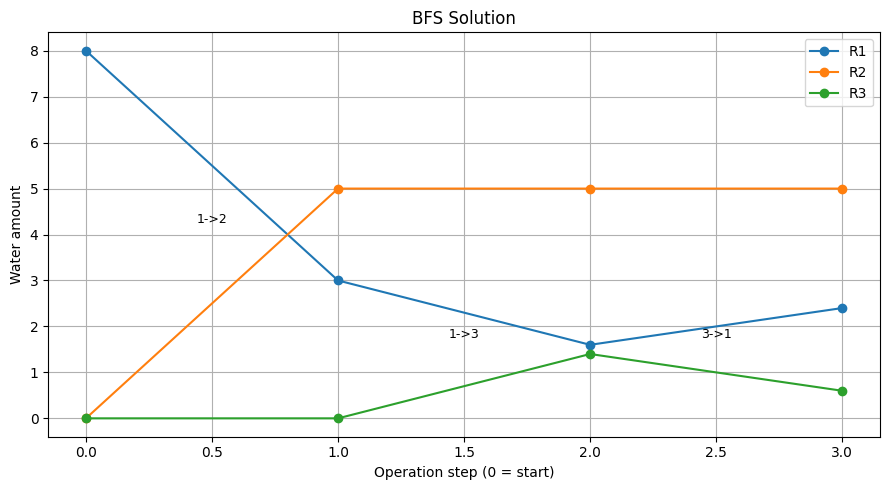

#Problem 3: The Game of Tic-Tac-Toe

Problem Statement:

Consider the game of tic-tac-toe where X is the MAX player. Given the game board below
where it is X’s turn to play next, show the game tree.

__ | X | __

0 | __ | __

X | __ | 0

The evaluation function on all the leaf nodes is given by:
Evaluation(s) = 8X3(s) + 3X2(s)+ X1(s) – (8O3(s) + 3O2(s) + O1(s)) Where Xn(s) is the number of
rows, columns, or diagonals in state s with exactly n number of X’s and no O’s and On(s) is the
number of rows, columns, or diagonals in states with exactly n number of O’s and no X’s.

Use the minimax algorithm and alpha-beta pruning algorithm to calculate the optimal move.


Initial Board:
_ X _
O _ _
X _ O

Plain Minimax -> Best Move: (0, 2) Score: 5
Alpha-Beta -> Best Move: (0, 2) Score: 5
Board After Alpha-Beta Move:
_ X X
O _ _
X _ O



#Problem 4:  Chip Placement Optimization using Integer Descent(Column-wise Restricted)
Problem Description:

We are given a grid matrix G of size W ×H. Each cell represents one unit of chip surface. A set of rectangular
chips (modules) must be placed on the grid.

• Each chip ci has width wi and height hi with hi > wi (tall rectangles).

• Each chip is locked to a specific row yi.

• The chip may only move horizontally by integer steps, i.e. its x-coordinate is always an integer.

• Some chips are connected via a netlist.

The objective is to place all chips on the grid such that the conflict score is minimized. We apply
gradient descent optimization: chips shift left/right in unit steps if this reduces the conflict score.

Conflict Score:

The conflict score is defined as:

Conflict(P ) = X
(ci,cj )∈Connections
WiringCost(ci, cj ) + X
(ci,cj )∈Overlaps
OverlapBlocks(ci, cj ).

1. Wiring Cost

For each pair of connected chips (ci, cj ):
WiringCost(ci, cj ) = max 0, xj − (xi + wi), xi − (xj + wj ) + |yi − yj |.
Here, xi are treated as integer variables.

2. Overlap Cost

Instead of continuous area, the overlap cost is the number of grid blocks occupied by more than one
chip:
OverlapBlocks(ci, cj ) = #grid cells covered by both ci and cj
.
This provides a discrete but easily interpretable penalty.
Initial State :

We work with a fixed instance on a 10 × 10 grid. All chips are taller than wide.
Chips (width × height), initial locked-row y and initial integer x:

c1 : 2 × 4 at row y = 0, (x = 0)

c2 : 2 × 5 at row y = 1, (x = 1)

c3 : 1 × 3 at row y = 0, (x = 1)

c4 : 2 × 5 at row y = 4, (x = 2)

c5 : 2 × 4 at row y = 3, (x = 3)

c6 : 1 × 4 at row y = 2, (x = 2)

c7 : 2 × 5 at row y = 5, (x = 0)

c8 : 1 × 3 at row y = 6, (x = 4)

Connections (netlist):

{(1, 2), (2, 6), (2, 3), (3, 5), (4, 5), (5, 6), (1, 6), (7, 4), (7, 2), (8, 5)}.

Tasks:

1. Implement integer descent to minimize the conflict score starting from the initial state above.
2. Track and plot the conflict score over iterations; report the final discrete conflict score.
3. Report final chip positions (xi, yi) and the final discrete conflict score.

Welcome to the Chip Placement Optimization System!
Circuit Board: 10 x 10 grid
Number of chips: 8
Number of connections: 10
Initial conflict score: 40

Initial Chip Arrangement:
y=9:   7   7   .   .   .   .   .   .   .   . 
y=8:   7   7   4   4   8   .   .   .   .   . 
y=7:   7   7   4   4   8   .   .   .   .   . 
y=6:   7   7   4 4/5 5/8   .   .   .   .   . 
y=5:   7 2/7 2/4/6 4/5   5   .   .   .   .   . 
y=4:   .   2 2/4/6 4/5   5   .   .   .   .   . 
y=3:   1 1/2 2/6   5   5   .   .   .   .   . 
y=2:   1 1/2/3 2/6   .   .   .   .   .   .   . 
y=1:   1 1/2/3   2   .   .   .   .   .   .   . 
y=0:   1 1/3   .   .   .   .   .   .   .   . 
x:     0   1   2   3   4   5   6   7   8   9
Starting chip placement optimization...
This might take a moment as we explore different arrangements...
Starting score: 40
Searching for better arrangements...
Step 1: Moved chip 3 right to position 2, improved score by 3.0
Step 2: Moved chip 2 left to position 0, improved score by 4.0
Step 3: Moved chip 5 

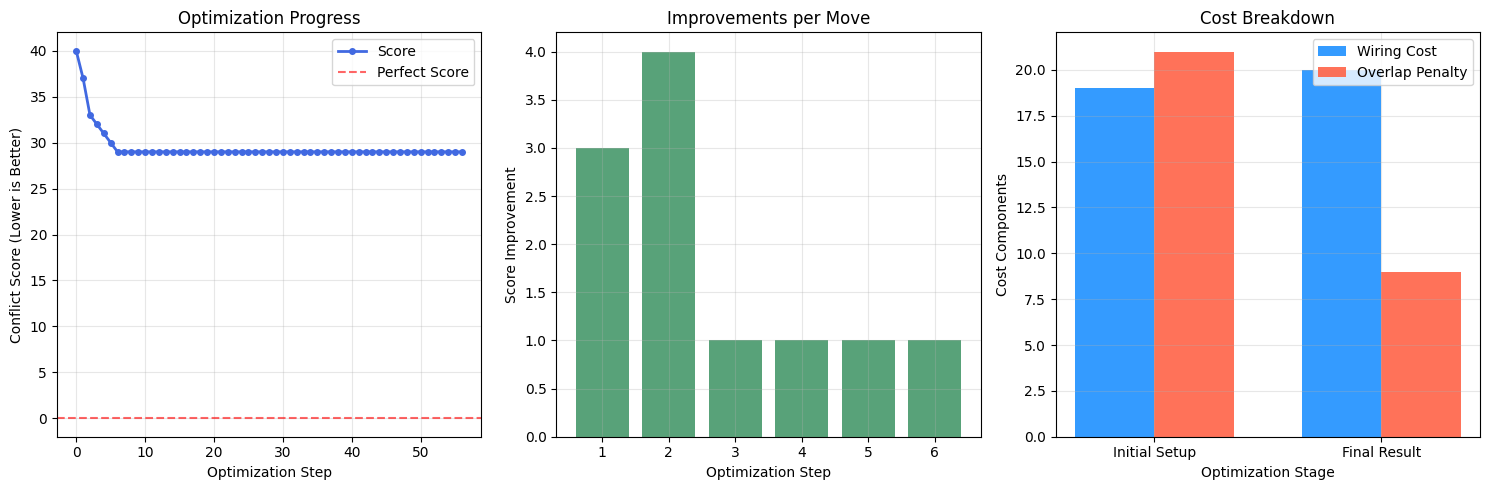


Optimization Complete!
Algorithm used: Greedy Hill Climbing with local search
Strategy: Iteratively move chips left/right to minimize conflicts
Termination: Stops when no beneficial moves remain
